# Improving NNs

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import numpy as np

# convert PIL image to normalized PyToch tensor
def image_to_tensor(image):
    return torch.tensor(np.array(image)) / 255.0


def preprocess_data(split):
    
    x = []  # list to store image tensors
    y = []  # list to store labels

    for example in split:
        x.append(image_to_tensor(example['image']))
        y.append(example['label'])
    
    return torch.stack(x), torch.tensor(y)

# set print options for PyTorch tensors
torch.set_printoptions(linewidth=140, sci_mode=False, precision=4)

# load the MNIST dataset
ds = load_dataset("ylecun/mnist")

# preprocess the data (we will see this function in Chapter 4)
train_x, train_y = preprocess_data(ds['train'])

# transform input tensor from (60000, 28, 28) to (60000, 784)
X = train_x.view(60000, 784)

N = 60000

## PyTorch

&ensp; &ensp; &ensp; &ensp; We can simplify the implementation of the neural network from the previous chapter using PyTorch functions. When initializing our neural network, we will set `p.requires_grad = True` to instruct PyTorch to track the gradient of the loss for those parameters. This enables us to use `loss.backward()` during the backward pass to calculate the gradient automatically. Additionally, we can use `F.cross_entropy()`, which efficiently applies Softmax and the average NLL.

In [2]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    W1 = torch.randn((784, n_hidden),      generator=g)
    b1 = torch.zeros(n_hidden)
    W2 = torch.randn((n_hidden, n_hidden), generator=g)
    b2 = torch.zeros(n_hidden)
    W3 = torch.randn((n_hidden, 10),       generator=g)
    b3 = torch.zeros(10)
    
    parameters = [W1, b1, W2, b2, W3, b3]

    for p in parameters:
        p.requires_grad = True      # keep track of gradient
        
    return parameters

In [3]:
epochs = 100       # train iterations
lr = 0.1           # learning rate

loss_graph = []

# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

for epoch in range(epochs):
    
    # forward pass
    h1 = torch.tanh(X @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    logits = h2 @ W3 + b3
    
    # calculate loss
    loss = F.cross_entropy(logits, train_y)
    loss_graph.append(loss.item())
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Step: {epoch:2d}/{epochs}     Loss: {loss.item():.4f}")
    
    # backward pass
    for p in parameters:
        p.grad = None       # reset gradient
    loss.backward()         # calculate gradient
    
    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

Step:  0/100     Loss: 15.9699
Step: 10/100     Loss: 10.9262
Step: 20/100     Loss: 8.3451
Step: 30/100     Loss: 6.7141
Step: 40/100     Loss: 5.6266
Step: 50/100     Loss: 4.8790
Step: 60/100     Loss: 4.3457
Step: 70/100     Loss: 3.9500
Step: 80/100     Loss: 3.6406
Step: 90/100     Loss: 3.3900
Step: 99/100     Loss: 3.2024


As shown in the graph below, the loss consistently decreased in each epoch.

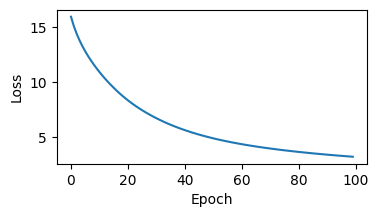

In [4]:
plt.figure(figsize=(4, 2))
plt.plot(loss_graph)
plt.xlabel('Epoch')
plt.ylabel('Loss');

## Batches

&ensp; &ensp; &ensp; &ensp; The neural network was progressively reducing the loss, and therefore learning. However, each epoch took a considerable amount of time because processing the entire dataset of 60,000 images is computationally expensive. To address this issue, in each iteration we will use a **batch**, a small randomly selected subset of the training dataset.

```{important}
When working with batches, we will refer to each training iteration as a **step**, not an epoch, because only a subset of the training dataset is processed in each iteration.  

```

```{admonition} Help
:class: dropdown
`torch.randint(0, N, (batch_size,))` randomly generates 32 integers between 0 and 60000 that we will use to index into the dataset.
```

In [5]:
steps = 100        # train iterations
lr = 0.1           # learning rate
batch_size = 32

loss_graph = []
g = torch.Generator().manual_seed(1)

# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

for step in range(steps):
    
    # batch construction
    ix = torch.randint(0, N, (batch_size,), generator=g)
    Xb = X[ix]
    Yb = train_y[ix]
    
    # forward pass
    h1 = torch.tanh(Xb @ W1 + b1)  # (32, 100) = (32, 784) x (784, 100) + (100)
    h2 = torch.tanh(h1 @ W2 + b2)  # (32, 100) = (32, 100) x (100, 100) + (100)
    logits = h2 @ W3 + b3          # (32,  10) = (32, 100) x (100,  10) + (10)
    
    # calculate loss
    loss = F.cross_entropy(logits, Yb)
    loss_graph.append(loss.item())
    if step % 10 == 0 or step == steps - 1:
        print(f"Step: {step:2d}/{steps}     Loss: {loss.item():.4f}")
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

Step:  0/100     Loss: 19.2715
Step: 10/100     Loss: 9.7469
Step: 20/100     Loss: 9.2240
Step: 30/100     Loss: 7.1574
Step: 40/100     Loss: 5.5388
Step: 50/100     Loss: 3.6040
Step: 60/100     Loss: 3.6486
Step: 70/100     Loss: 5.2210
Step: 80/100     Loss: 3.3407
Step: 90/100     Loss: 2.6224
Step: 99/100     Loss: 3.0554


&ensp; &ensp; &ensp; &ensp; Because we are using a subset of the dataset, we are computing an approximate gradient instead of the exact gradient. As a result, the loss may temporarily increase during some steps, as shown in the graph below. However, the use of approximate gradients enables faster iterations, which is often better than slower iterations with exact gradients.

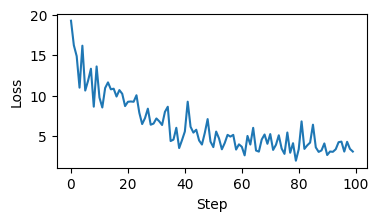

In [6]:
plt.figure(figsize=(4, 2))
plt.plot(loss_graph)
plt.xlabel('Step')
plt.ylabel('Loss');

The loss we are seeing is the loss of each batch. To compute the train loss we have to use the whole train dataset.

In [7]:
def train_loss():

    # forward pass
    h1 = torch.tanh(X @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    logits = h2 @ W3 + b3

    # calculate loss
    loss = F.cross_entropy(logits, train_y)
    
    return loss.item()

print(f"Train Loss: {train_loss():.4f}")

Train Loss: 3.3288


## Saturated Softmax

&ensp; &ensp; &ensp; &ensp; Our neural network is facing several issues that are hindering its learning process. To identify and address these issues, we will perform a single training iteration slightly modifying the code to track the pre-activations and the gradients of each layer.

In [8]:
g = torch.Generator().manual_seed(1)

# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

# batch construction
ix = torch.randint(0, N, (batch_size,), generator=g)
Xb = X[ix]
Yb = train_y[ix]

# forward pass
h1_pre = Xb @ W1 + b1       # 1st layer pre-activations
h1 = torch.tanh(h1_pre)
h1_pre.retain_grad()            # track gradient

h2_pre = h1 @ W2 + b2       # 2nd layer pre-activations
h2 = torch.tanh(h2_pre)
h2_pre.retain_grad()            # track gradient

logits = h2 @ W3 + b3
probs = logits.exp() / logits.exp().sum(1, keepdims=True)

# calculate loss
loss = -probs[range(batch_size), Yb].log().mean()

# backward pass
for p in parameters:
    p.grad = None
h1_pre.grad = None              # reset gradient
h2_pre.grad = None              # reset gradient
loss.backward()

At initialization, the model should assign roughly equal probabilities (1/10) to all classes. Therefore, we expect the initialization loss to be approximately:

<br>

$$
\text{Initialization Loss:} = -\log\left(\frac{1}{10}\right) = 2.3026
$$

<br>

However, at initialization, we obtained a much higher loss of 19.2715. The issue is that the Softmax function is saturated because the logits produced by the neural network are extremely random positive or negative numbers. When these extreme values are passed through the Softmax function, they result in probabilities close to 0 or 1. As a result, the model often assigns a very high probability to the incorrect class, leading to a significantly high loss.

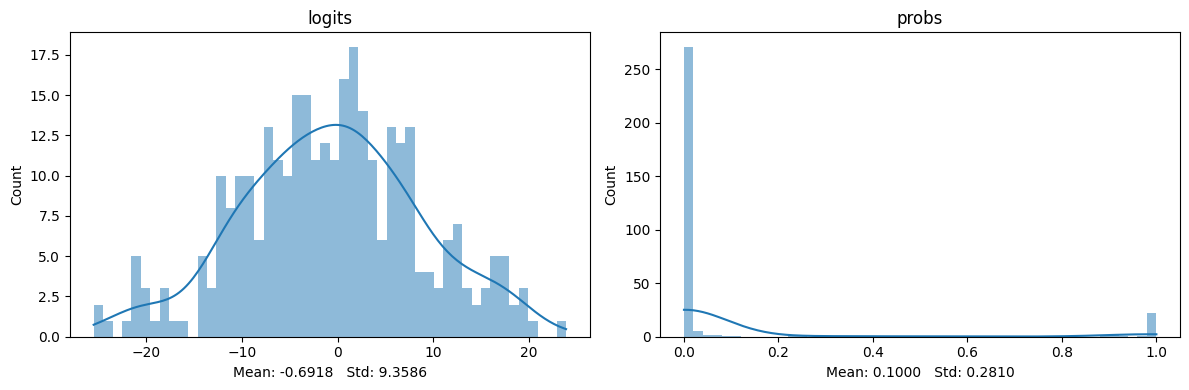

In [9]:
plt.figure(figsize=(12,4))

plt.subplot(121)
sns.histplot(logits.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('logits')
plt.xlabel(f'Mean: {logits.mean():.4f}   Std: {logits.std():.4f}')

plt.subplot(122)
sns.histplot(probs.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('probs')
plt.xlabel(f'Mean: {probs.mean():.4f}   Std: {probs.std():.4f}')

plt.tight_layout()

To address the saturated Softmax issue, we will scale the weights of the last layer by a factor of 0.01.

In [17]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    W1 = torch.randn((784, n_hidden),      generator=g)
    b1 = torch.zeros(n_hidden)
    W2 = torch.randn((n_hidden, n_hidden), generator=g)
    b2 = torch.zeros(n_hidden)
    W3 = torch.randn((n_hidden, 10),       generator=g) * 0.01
    b3 = torch.zeros(10)
    
    parameters = [W1, b1, W2, b2, W3, b3]

    for p in parameters:
        p.requires_grad = True
    
    return parameters

In [18]:
g = torch.Generator().manual_seed(1)

# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

# batch construction
ix = torch.randint(0, N, (batch_size,), generator=g)
Xb = X[ix]
Yb = train_y[ix]

# forward pass
h1_pre = Xb @ W1 + b1       # 1st layer pre-activations
h1 = torch.tanh(h1_pre)
h1_pre.retain_grad()            # track gradient

h2_pre = h1 @ W2 + b2       # 2nd layer pre-activations
h2 = torch.tanh(h2_pre)
h2_pre.retain_grad()            # track gradient

logits = h2 @ W3 + b3
probs = logits.exp() / logits.exp().sum(1, keepdims=True)

# calculate loss
loss = -probs[range(batch_size), Yb].log().mean()

# backward pass
for p in parameters:
    p.grad = None
h1_pre.grad = None              # reset gradient
h2_pre.grad = None              # reset gradient
loss.backward()

With this adjustment, the logits produced by the neural network are closer to 0, leading to more balanced probabilities (approximately 1/10) across all classes and an initialization loss of 2.3447.

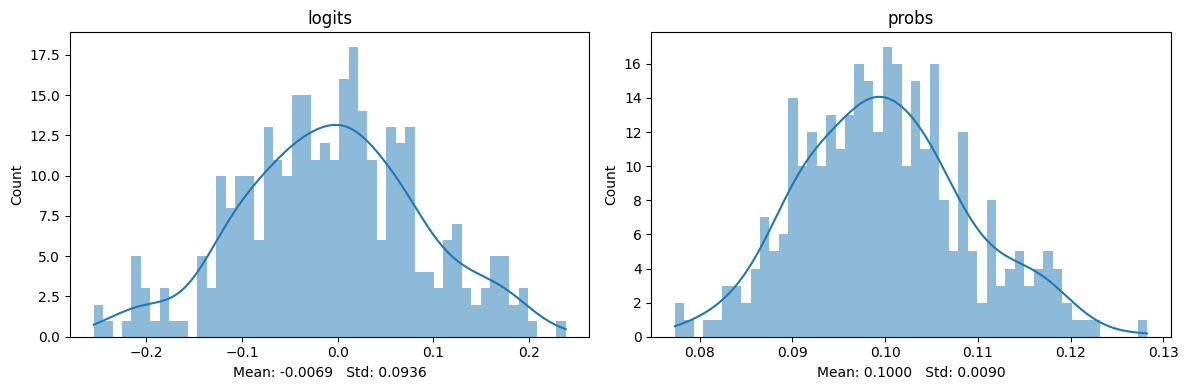

In [12]:
plt.figure(figsize=(12,4))

plt.subplot(121)
sns.histplot(logits.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('logits')
plt.xlabel(f'Mean: {logits.mean():.4f}   Std: {logits.std():.4f}')

plt.subplot(122)
sns.histplot(probs.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('probs')
plt.xlabel(f'Mean: {probs.mean():.4f}   Std: {probs.std():.4f}')

plt.tight_layout()

## Saturated Tanh

The Tanh activation function becomes saturated when neuron pre-activations are extremely positive or negative. In such cases, the Tanh function returns activations that are approximately 1 and -1, as shown in the graph below:

```{figure} ../images/tanh.png
---
width: 300px
name: tanh
---
tanh (Hyperbolic Tangent). Source: {cite}`weisstein_tanh`
```

Approximately 1 and -1 activations make the gradient approximately 0 when we backpropagate through Tanh:

<br>

$$
h2 = tanh(h2\_pre) \quad \Rightarrow \quad dh2\_pre = (1 - (h2)^2) \cdot dh2 \\
h1 = tanh(h1\_pre) \quad \Rightarrow \quad dh1\_pre = (1 - (h1)^2) \cdot dh1
$$

The problem with an approximately 0 gradient is that the network barely updates its parameters slowing down learning.

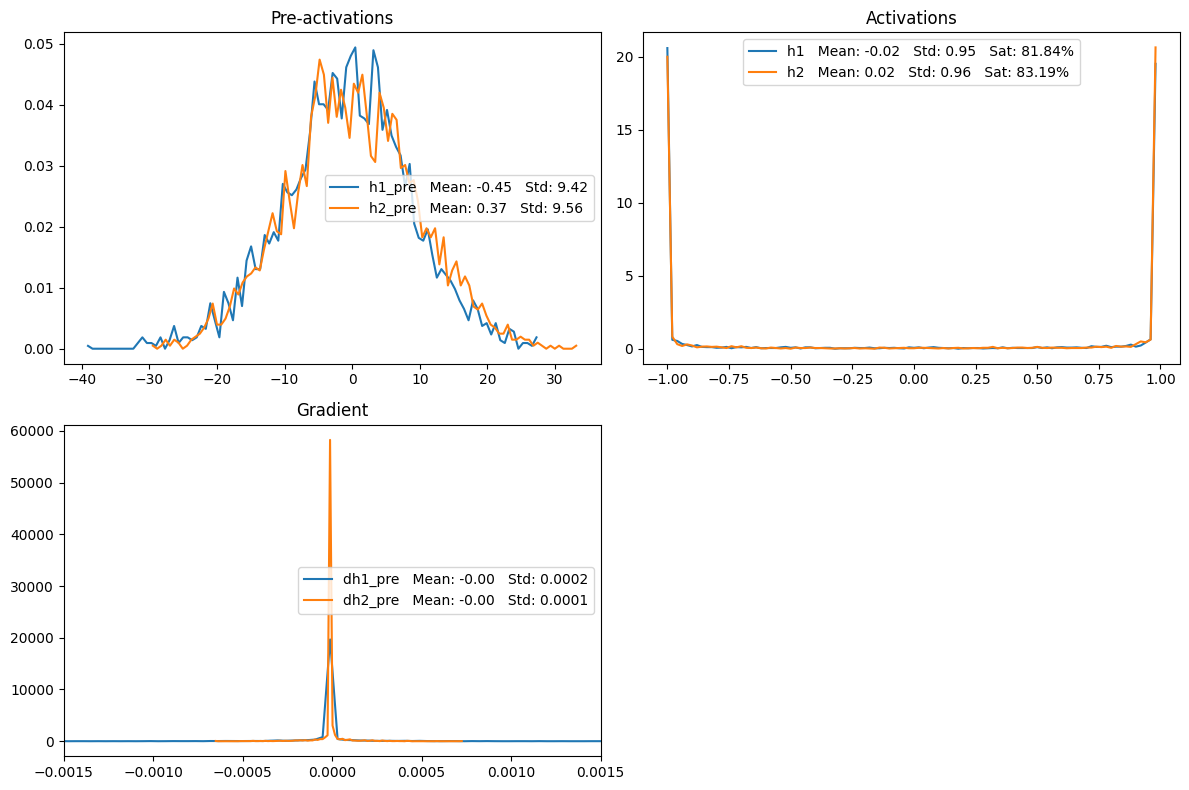

In [19]:
plt.figure(figsize=(12,8))

# pre-activations distribution
plt.subplot(221)
hy, hx = torch.histogram(h1_pre, density=True)
plt.plot(hx[:-1].detach(), hy.detach(), label=f'h1_pre   Mean: {h1_pre.mean():.2f}   Std: {h1_pre.std():.2f}')
hy, hx = torch.histogram(h2_pre, density=True)
plt.plot(hx[:-1].detach(), hy.detach(), label=f'h2_pre   Mean: {h2_pre.mean():.2f}   Std: {h2_pre.std():.2f}')
plt.title('Pre-activations')
plt.legend()

# activations distribution
plt.subplot(222)
hy, hx = torch.histogram(h1, density=True)
plt.plot(hx[:-1].detach(), hy.detach(), label=f'h1   Mean: {h1.mean():.2f}   Std: {h1.std():.2f}   Sat: {(h1.abs() > 0.97).float().mean()*100:.2f}%')
hy, hx = torch.histogram(h2, density=True)
plt.plot(hx[:-1].detach(), hy.detach(), label=f'h2   Mean: {h2.mean():.2f}   Std: {h2.std():.2f}   Sat: {(h2.abs() > 0.97).float().mean()*100:.2f}%')
plt.title('Activations')
plt.legend()

# gradients distribution
plt.subplot(223)
hy, hx = torch.histogram(h1_pre.grad, density=True)
plt.plot(hx[:-1].detach(), hy.detach(), label=f'dh1_pre   Mean: {h1_pre.grad.mean():.2f}   Std: {h1_pre.grad.std():.4f}')
hy, hx = torch.histogram(h2_pre.grad, density=True)
plt.plot(hx[:-1].detach(), hy.detach(), label=f'dh2_pre   Mean: {h2_pre.grad.mean():.2f}   Std: {h2_pre.grad.std():.4f}')
plt.title('Gradient')
plt.xlim(-0.0015, 0.0015)
plt.legend()

plt.tight_layout()

## Kaiming Initialization

**Kaiming initialization**, also known as He initialization, is a method for initializing neural network weights to avoid excessively large or small pre-activations. It was introduced in the paper [He et al. (2015). *Delving Deep into Rectifiers*](https://arxiv.org/pdf/1502.01852). Kaiming initialization adjusts the weights using a scaling factor determined by the activation function's gain and the number of inputs to the neuron, $fan\_in$.

<br>

$$
W \sim \frac{\text{gain}}{\sqrt{fan\_in}}
$$

In [20]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    W1 = torch.randn((784, n_hidden),      generator=g) * (5/3) / 784**0.5
    b1 = torch.zeros(n_hidden)
    W2 = torch.randn((n_hidden, n_hidden), generator=g) * (5/3) / n_hidden**0.5
    b2 = torch.zeros(n_hidden)
    W3 = torch.randn((n_hidden, 10),       generator=g) * 0.01
    b3 = torch.zeros(10)
    
    parameters = [W1, b1, W2, b2, W3, b3]

    for p in parameters:
        p.requires_grad = True
    
    return parameters

In [21]:
g = torch.Generator().manual_seed(1)

# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

# batch construction
ix = torch.randint(0, N, (batch_size,), generator=g)
Xb = X[ix]
Yb = train_y[ix]

# forward pass
h1_pre = Xb @ W1 + b1       # 1st layer pre-activations
h1 = torch.tanh(h1_pre)
h1_pre.retain_grad()            # track gradient

h2_pre = h1 @ W2 + b2       # 2nd layer pre-activations
h2 = torch.tanh(h2_pre)
h2_pre.retain_grad()            # track gradient

logits = h2 @ W3 + b3
probs = logits.exp() / logits.exp().sum(1, keepdims=True)

# calculate loss
loss = -probs[range(batch_size), Yb].log().mean()

# backward pass
for p in parameters:
    p.grad = None
h1_pre.grad = None              # reset gradient
h2_pre.grad = None              # reset gradient
loss.backward()

With this adjustment, the pre-activations are not excesive large or small, there are fewer approximately 1 and -1 activations, and therefore, the gradient is not approximately 0.

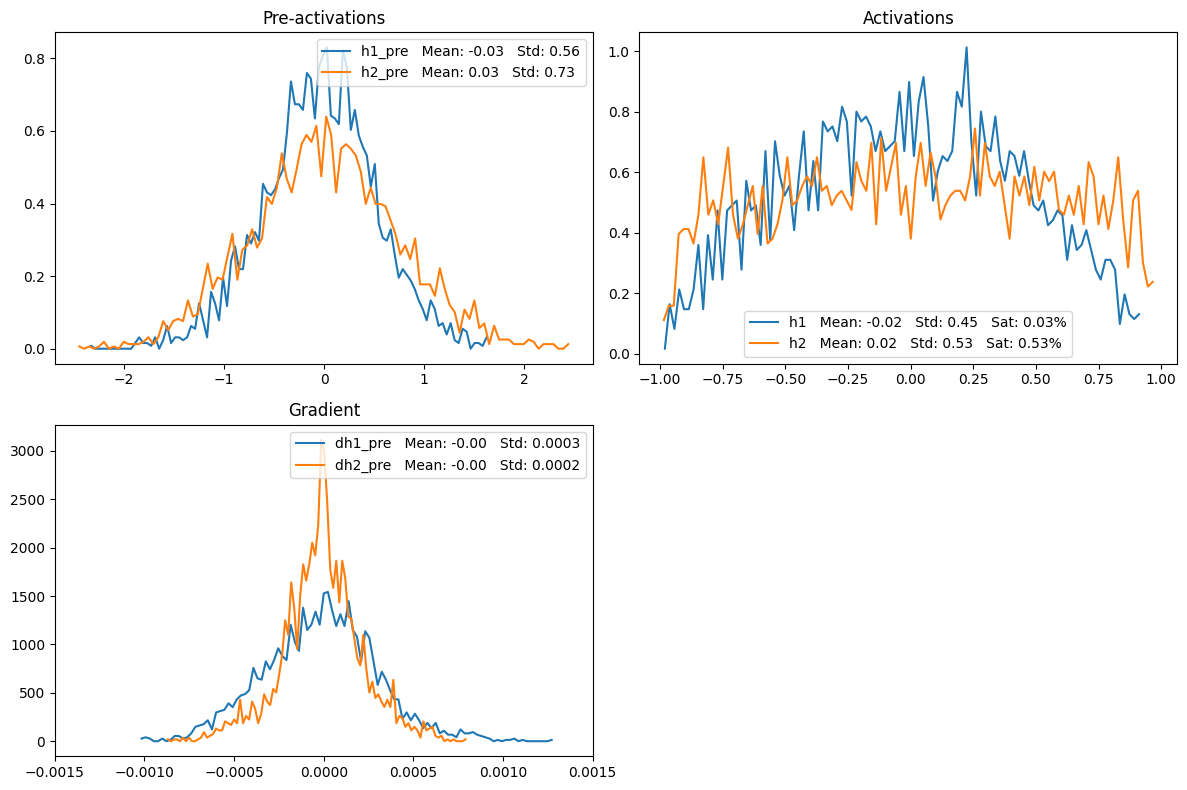

In [57]:
plt.figure(figsize=(12,8))

# pre-activations distribution
plt.subplot(221)
hy, hx = torch.histogram(h1_pre, density=True)
plt.plot(hx[:-1].detach(), hy.detach(), label=f'h1_pre   Mean: {h1_pre.mean():.2f}   Std: {h1_pre.std():.2f}')
hy, hx = torch.histogram(h2_pre, density=True)
plt.plot(hx[:-1].detach(), hy.detach(), label=f'h2_pre   Mean: {h2_pre.mean():.2f}   Std: {h2_pre.std():.2f}')
plt.title('Pre-activations')
plt.legend()

# activations distribution
plt.subplot(222)
hy, hx = torch.histogram(h1, density=True)
plt.plot(hx[:-1].detach(), hy.detach(), label=f'h1   Mean: {h1.mean():.2f}   Std: {h1.std():.2f}   Sat: {(h1.abs() > 0.97).float().mean()*100:.2f}%')
hy, hx = torch.histogram(h2, density=True)
plt.plot(hx[:-1].detach(), hy.detach(), label=f'h2   Mean: {h2.mean():.2f}   Std: {h2.std():.2f}   Sat: {(h2.abs() > 0.97).float().mean()*100:.2f}%')
plt.title('Activations')
plt.legend()

# gradients distribution
plt.subplot(223)
hy, hx = torch.histogram(h1_pre.grad, density=True)
plt.plot(hx[:-1].detach(), hy.detach(), label=f'dh1_pre   Mean: {h1_pre.grad.mean():.2f}   Std: {h1_pre.grad.std():.4f}')
hy, hx = torch.histogram(h2_pre.grad, density=True)
plt.plot(hx[:-1].detach(), hy.detach(), label=f'dh2_pre   Mean: {h2_pre.grad.mean():.2f}   Std: {h2_pre.grad.std():.4f}')
plt.title('Gradient')
plt.xlim(-0.0015, 0.0015)
plt.legend()

plt.tight_layout()

## Vanishing Gradient

&ensp; &ensp; &ensp; &ensp; Please note in the gradient graph that the gradient of the loss with respect to the second layer's pre-activations is smaller than the gradient of the loss with respect to the first layer's pre-activations. This phenomenon, known as the **vanishing gradient** problem, is an issue because the first layer is learning faster than the second layer. As the network depth increases, this problem becomes more pronounced.

&ensp; &ensp; &ensp; &ensp; To check this, we will now construct a deeper neural network consisting of four hidden layers. From now on, instead of using tensors to build our networks, we will take a modular approach. We will our neural networks using different layers as building blocks that are stacked. Thus, we will adopt an object-oriented programming approach and create classes for each type of layer, enabling a more flexible and scalable neural network design.

In [37]:
class Linear:

    def __init__(self, fan_in, fan_out, g, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])



class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [90]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    layers = [
        Linear(     784, n_hidden, g), Tanh(),
        Linear(n_hidden, n_hidden, g), Tanh(),
        Linear(n_hidden, n_hidden, g), Tanh(),
        Linear(n_hidden, n_hidden, g), Tanh(),
        Linear(n_hidden,       10, g),
    ]
    
    with torch.no_grad():
        
        layers[-1].weight *= 0.01           # make less confident last layer

        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= 5/3         # apply kaiming gain
    
    parameters = [p for layer in layers for p in layer.parameters()]
    
    for p in parameters:
        p.requires_grad = True
    
    return layers, parameters

In [91]:
g = torch.Generator().manual_seed(1)

# intialize neural network
layers, parameters = initialize_nn()
 
# batch construction
ix = torch.randint(0, N, (batch_size,), generator=g)
Xb = X[ix]
Yb = train_y[ix]

# forward pass
x = Xb
for layer in layers:
    x = layer(x)
    layer.out.retain_grad() # track gradient

# calculate loss
loss = F.cross_entropy(x, Yb)
    
# backward pass
for p in parameters:
    p.grad = None
loss.backward()

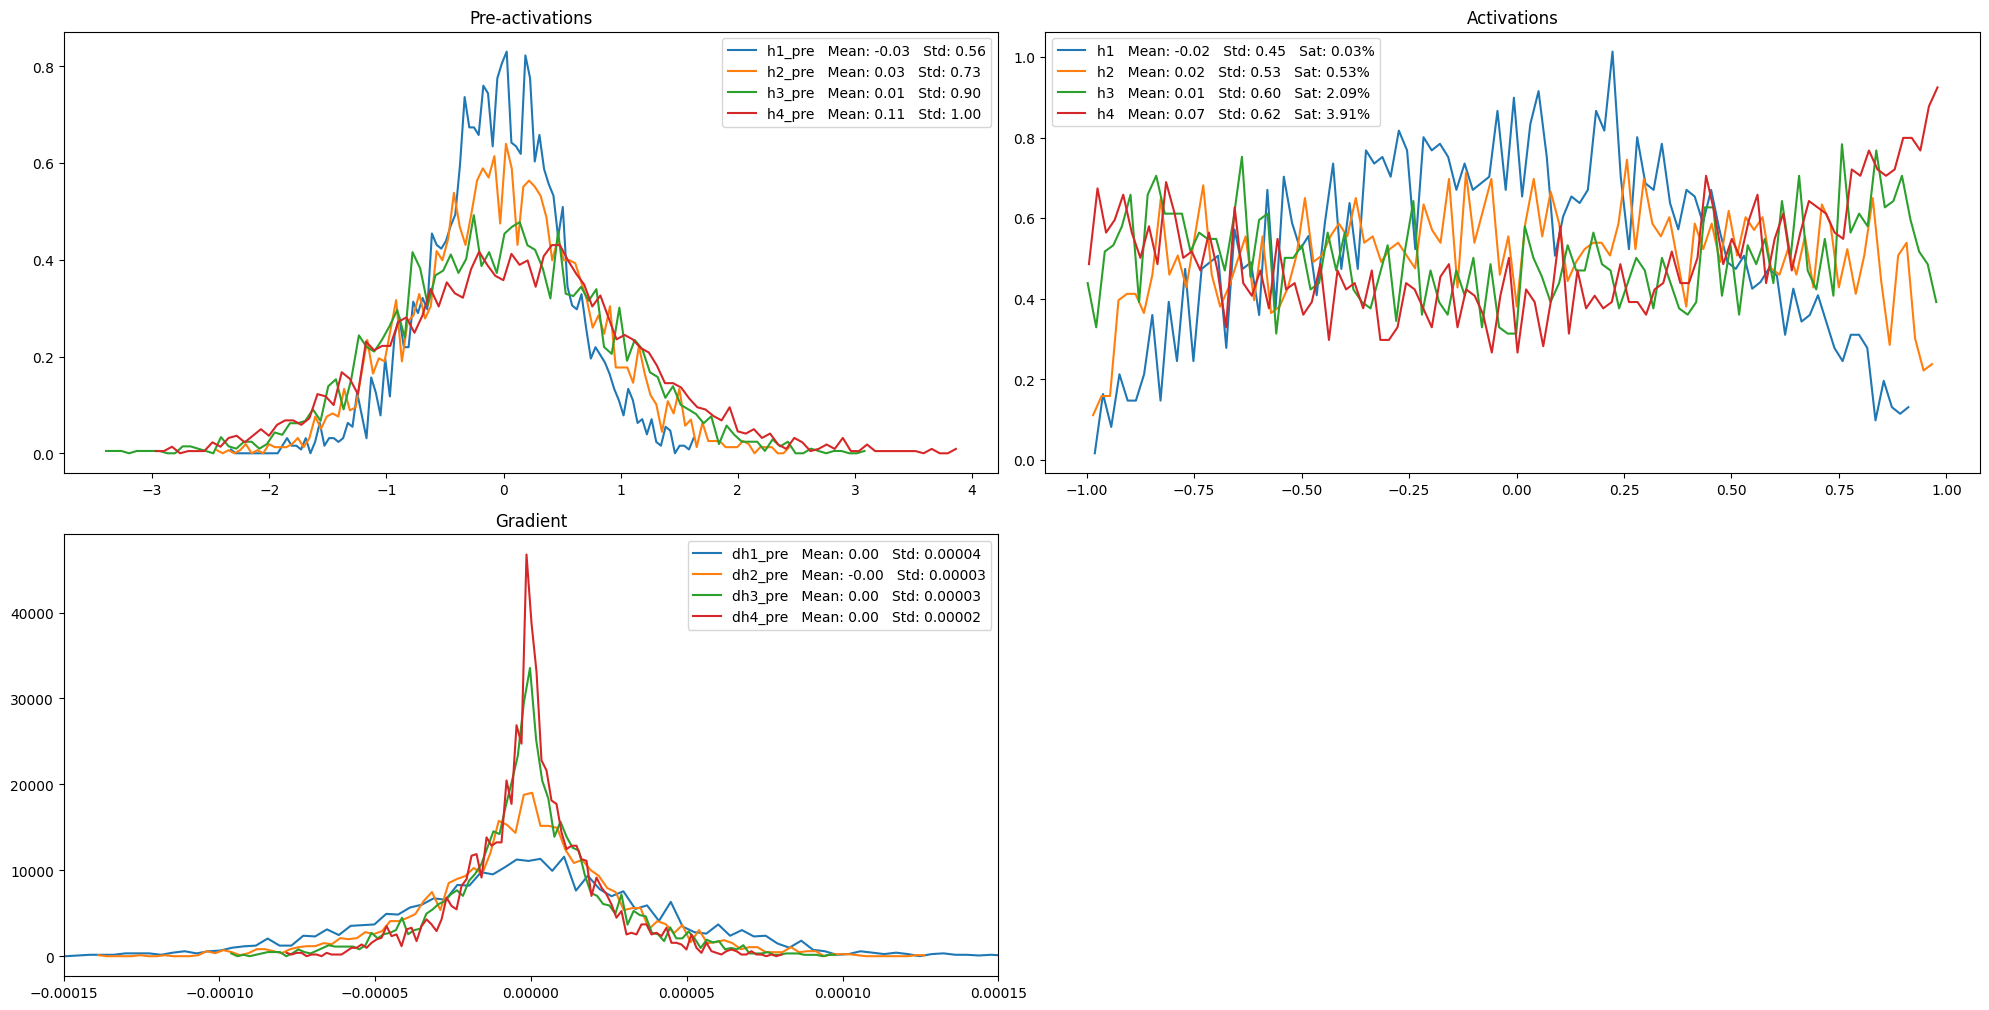

In [97]:
plt.figure(figsize=(20, 15))
legends = []

i = 1

for layer in layers[:-1]:

    if isinstance(layer, Linear):
        h_pre = layer.out
        dh_pre = layer.out.grad

        # pre-activations distribution
        plt.subplot(3, 2, 1)
        hy, hx = torch.histogram(h_pre, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=f'h{i}_pre   Mean: {h_pre.mean():.2f}   Std: {h_pre.std():.2f}')
        plt.title('Pre-activations')
        plt.legend()

        # gradients distribution
        plt.subplot(3, 2, 3)
        hy, hx = torch.histogram(dh_pre, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=f'dh{i}_pre   Mean: {dh_pre.mean():.2f}   Std: {dh_pre.std():.5f}')
        plt.title('Gradient')
        plt.xlim(-0.00015, 0.00015)
        plt.legend()
    
    if isinstance(layer, Tanh):
        h = layer.out

        # activations distribution
        plt.subplot(3, 2, 2)
        hy, hx = torch.histogram(h, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=f'h{i}   Mean: {h.mean():.2f}   Std: {h.std():.2f}   Sat: {(h.abs() > 0.97).float().mean()*100:.2f}%')
        plt.title('Activations')
        plt.legend()
        
        i += 1

plt.tight_layout()

## Batch Normalization

In [98]:
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        self.gain = torch.ones(dim)
        self.bias = torch.zeros(dim)
        self.r_mean = torch.zeros(dim)
        self.r_var = torch.ones(dim)
    
    def __call__(self, x):

        # calculate forward pass
        if self.training:
            mean = x.mean(0, keepdim=True)
            var = x.var(0, keepdim=True)
        else:
            mean = self.r_mean
            var = self.r_var
        self.out = self.gain * (x - mean) / torch.sqrt(var + self.eps) + self.bias
        
        # update buffers
        if self.training:
            with torch.no_grad():
                self.r_mean = (1 - self.momentum) * self.r_mean + self.momentum * mean
                self.r_var = (1 - self.momentum) * self.r_var + self.momentum * var
        
        return self.out
    
    def parameters(self):
        return [self.gain, self.bias]

In [99]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    layers = [
        Linear(     784, n_hidden, g, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_hidden, g, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_hidden, g, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_hidden, g, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden,       10, g, bias=False),
    ]
    
    with torch.no_grad():
        
        layers[-1].weight *= 0.01           # make less confident last layer

        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= 5/3         # apply kaiming gain
    
    parameters = [p for layer in layers for p in layer.parameters()]
    
    for p in parameters:
        p.requires_grad = True
    
    return layers, parameters

In [100]:
g = torch.Generator().manual_seed(1)

# intialize neural network
layers, parameters = initialize_nn()
 
# batch construction
ix = torch.randint(0, N, (batch_size,), generator=g)
Xb = X[ix]
Yb = train_y[ix]

# forward pass
x = Xb
for layer in layers:
    x = layer(x)

# track gradient
for layer in layers:
    layer.out.retain_grad()

# calculate loss
loss = F.cross_entropy(x, Yb)

# backward pass
for p in parameters:
    p.grad = None
loss.backward()

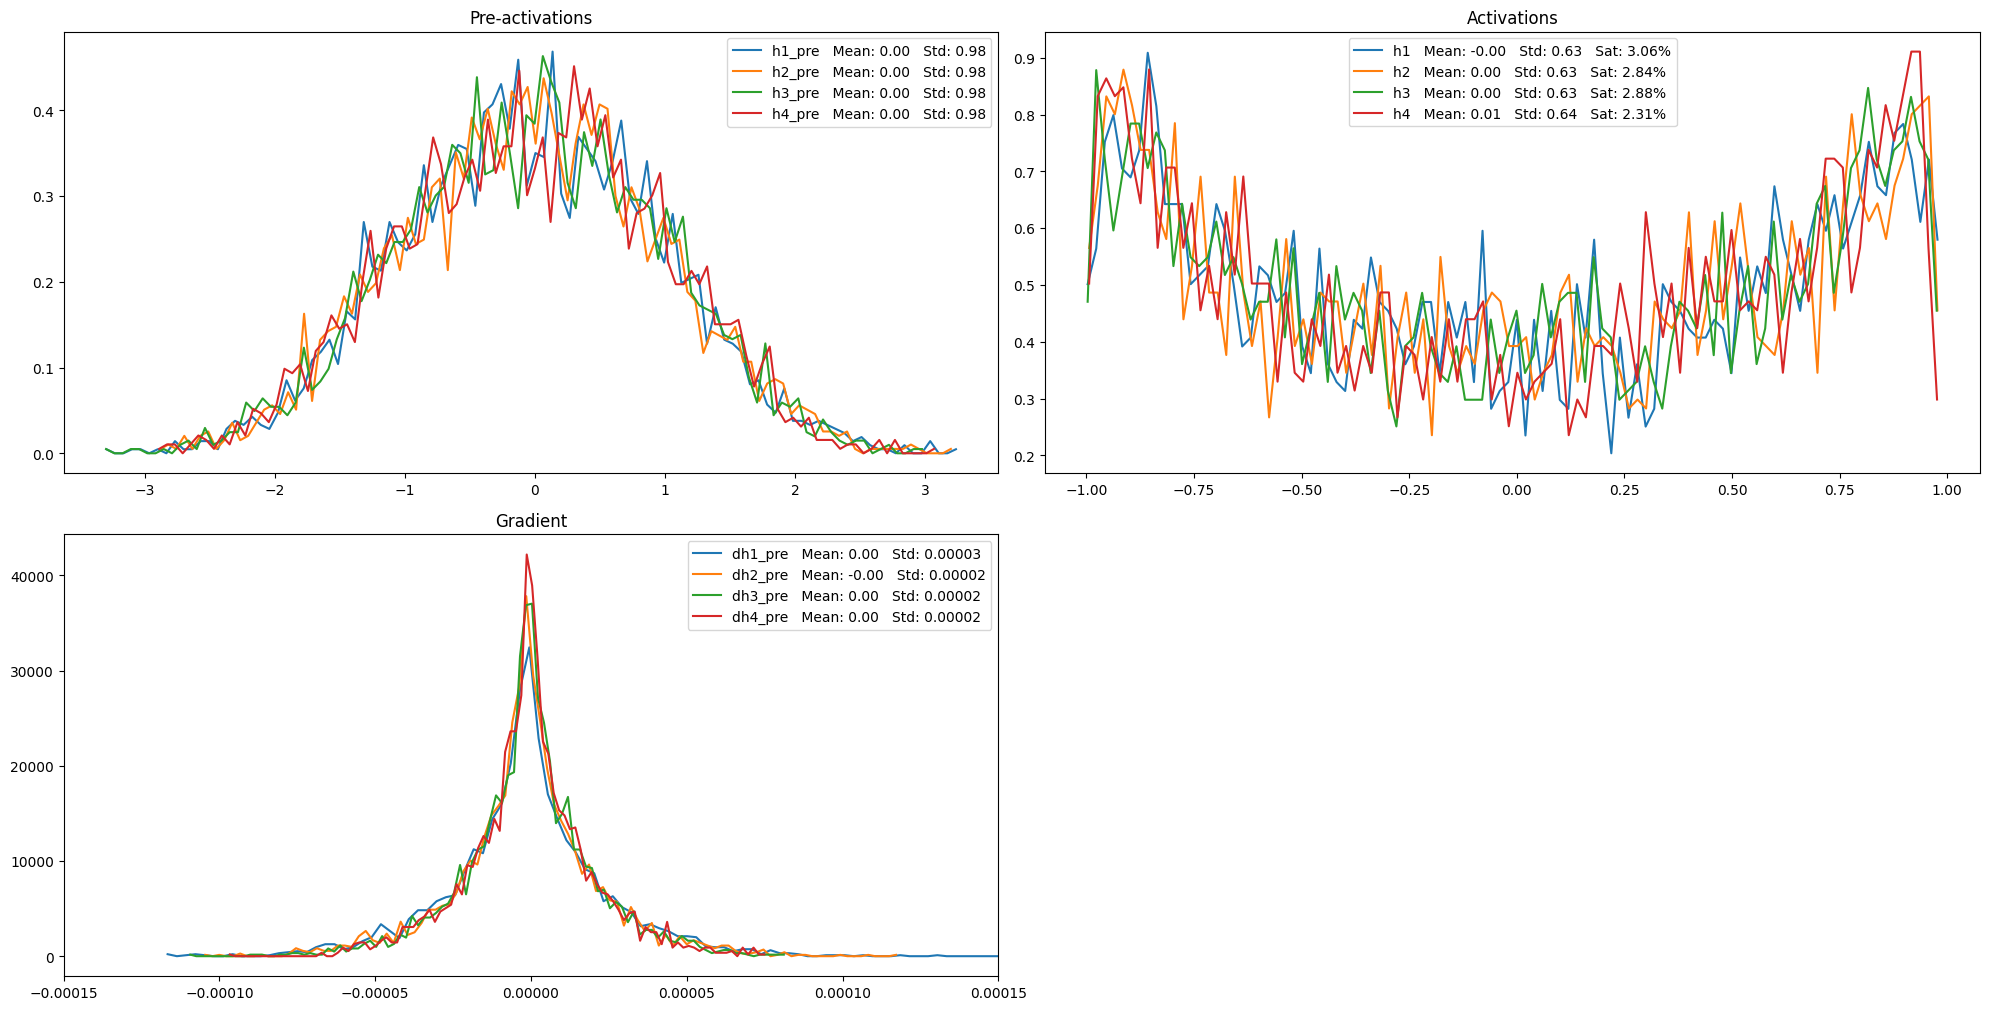

In [101]:
plt.figure(figsize=(20, 15))
legends = []

i = 1

for layer in layers[:-1]:

    if isinstance(layer, BatchNorm1d):
        h_pre = layer.out
        dh_pre = layer.out.grad

        # pre-activations distribution
        plt.subplot(3, 2, 1)
        hy, hx = torch.histogram(h_pre, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=f'h{i}_pre   Mean: {h_pre.mean():.2f}   Std: {h_pre.std():.2f}')
        plt.title('Pre-activations')
        plt.legend()

        # gradients distribution
        plt.subplot(3, 2, 3)
        hy, hx = torch.histogram(dh_pre, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=f'dh{i}_pre   Mean: {dh_pre.mean():.2f}   Std: {dh_pre.std():.5f}')
        plt.title('Gradient')
        plt.xlim(-0.00015, 0.00015)
        plt.legend()
    
    if isinstance(layer, Tanh):
        h = layer.out

        # activations distribution
        plt.subplot(3, 2, 2)
        hy, hx = torch.histogram(h, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=f'h{i}   Mean: {h.mean():.2f}   Std: {h.std():.2f}   Sat: {(h.abs() > 0.97).float().mean()*100:.2f}%')
        plt.title('Activations')
        plt.legend()
        
        i += 1

plt.tight_layout()

a